In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from scipy import stats

# Load data

In [2]:
temperature = pd.read_csv("data/data-map-temperature.txt")
print(len(temperature))
temperature.head(5)

47


,prefID,Y
0,1,9.2
1,2,10.5
2,3,10.6
3,4,12.7
4,5,11.9


In [3]:
neighbor = pd.read_csv("data/data-map-neighbor.txt")
print(len(neighbor))
neighbor.head(5)

100


,From,To
0,1,2
1,2,5
2,2,3
3,3,5
4,3,4


(array([ 3.,  2.,  3.,  4., 11., 20.,  3.,  0.,  0.,  1.]),
 array([ 9.2 , 10.61, 12.02, 13.43, 14.84, 16.25, 17.66, 19.07, 20.48,
        21.89, 23.3 ]),
 <BarContainer object of 10 artists>)

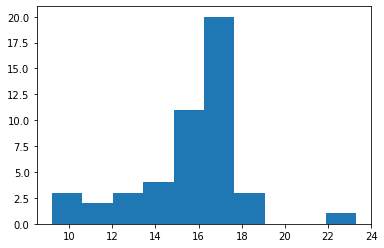

In [4]:
plt.hist(temperature["Y"])

# Run Stan

In [5]:
model = CmdStanModel(stan_file="model/model12-14.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap12/model/model12-14


CmdStanModel: name=model12-14
	 stan_file=/workdir/chap12/model/model12-14.stan
	 exe_file=/workdir/chap12/model/model12-14
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
data = {
    "N": len(temperature),
    "Y": temperature["Y"].values,
    "I": len(neighbor),
    "From": neighbor["From"].values,
    "To": neighbor["To"].values
}

In [7]:
# did not converge when inits was removed
fit = model.sample(
    data=data, 
    inits={
        "r": temperature["Y"].values, 
        "s_Y": 0.1,
        "s_r": 0.1
    }
)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [8]:
summary = fit.summary()
summary[summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


# Plot the result

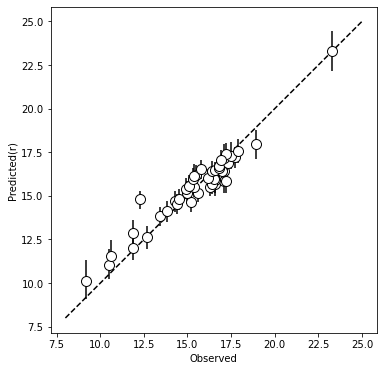

In [9]:
# Figure 12.11 left

r_percentiles = np.percentile(fit.stan_variable("r"), [2.5, 50.0, 97.5], axis=0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.plot([8.0, 25.0], [8.0, 25.0], "k--")
ax.errorbar(
    x=temperature["Y"].values, 
    y=r_percentiles[1], 
    yerr=np.abs(r_percentiles[[0, 2]] - r_percentiles[1]),
    fmt="o",
    ecolor='k',
    markerfacecolor='w',
    markeredgecolor='k',
    markersize=10
)

ax.set_aspect("equal")
ax.set_xlabel("Observed")
ax.set_ylabel("Predicted(r)")
fig.show()

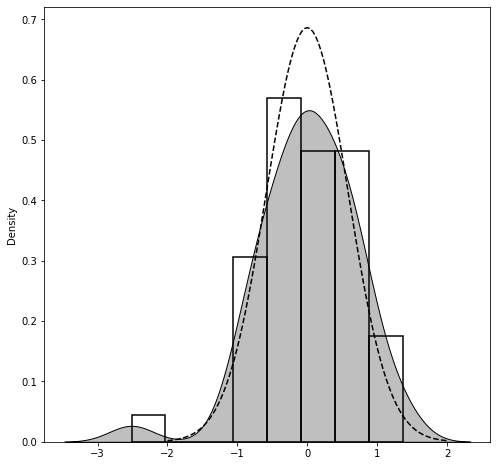

In [11]:
# Figure 12.11 right

diff = np.median(temperature["Y"].values - fit.stan_variable("r"), axis=0)

fig = plt.figure(figsize=(8, 8))
xx = np.linspace(-2, 2, 101)

ax = fig.add_subplot(111)
sns.histplot(ax=ax, x=diff, stat="density", fill=False, color='k')
sns.kdeplot(ax=ax, x=diff, fill=True, color="k")
ax.plot(xx, stats.norm(loc=0, scale=fit.stan_variable("s_Y").mean()).pdf(xx), "k--")
fig.show()